In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
from funkwpap import *
import sympy as sp, pandas as pd, numpy as np, tqdm, time, sys, matplotlib.pyplot as plt, tqdm
from statistics import mean
from scipy.optimize import fsolve
import gurobipy as gb



In [2]:
x = sp.symbols('x')
cap = 2000 # total emission cap
Regulator27 = Regulator("test1", permit_price = 2.4079, emission_cap = cap)
sector1 = Sector('cement', price_demand_function= 100 - 0.1*x, free_emission_multiplier= 0, regulator= Regulator27)
sector2 = Sector('steel', price_demand_function=150 - 0.1*x, free_emission_multiplier= 0, regulator= Regulator27)
sector3 = Sector('paper', price_demand_function= 200 - 0.02*x**1.5, free_emission_multiplier= 0, regulator= Regulator27)
country1 = Country('DE', 1, regulator= Regulator27)
country2 = Country('FI', 0.5, regulator= Regulator27)
country3 = Country('GR', size= 0.1, regulator= Regulator27)

# Create Firms using objects
firm1 = Firm('firm1', 1, 1, x*0, 2*x+ 2*x**2 + 2*x**3 , 0, 0, 0, regulator= Regulator27)
firm2 = Firm('firm2', 1, 2, x*0, 3*x+ 3*x**2 + 2*x**3, 0, 0, 0, regulator= Regulator27)
firm3 = Firm('firm3', 1, 3, x*0, 1*x+ 3*x**2 + 2*x**3 , 0, 0, 0, regulator= Regulator27)
firm4 = Firm('firm4', 2, 1, x*0, 7*x+ 5*x**2 + 3*x**3 , 0, 0, 0, regulator= Regulator27)
firm5 = Firm('firm5', 2, 2, x*0, 1*x+ 6*x**2 + 2*x**3 , 0, 0, 0, regulator= Regulator27)
firm6 = Firm('firm6', 2, 3, x*0, 2*x+ 7*x**2 + 3*x**3 , 0, 0, 0, regulator= Regulator27)
firm7 = Firm('firm7', 3, 1, x*0, 3*x+ 8*x**2 + 4*x**3 , 0, 0, 0, regulator= Regulator27)
firm8 = Firm('firm8', 3, 2, x*0, 4*x+ 9*x**2 + 10*x**3 , 0, 0, 0, regulator= Regulator27)
firm9 = Firm('firm9', 3, 3, x*0, 5*x+ 10*x**2 + 11*x**3 , 0, 0, 0, regulator= Regulator27)



In [3]:
Regulator27.BAU_calculator()

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-14


In [4]:
def optimize_with_abatement_efficiency_reward(abatement_reward_multiplier = 0, regulator = Regulator27, gurobi_print = False, lp_file = "optimize_with_abatement_efficiency_reward.lp", print_output = False):
    
        m = Model("optimization_concave_formulation_ab")
        
        # Define one pair of output and emission for each firm for sympy and for gurobi and the dictionary of them
        symbol_map = {}
        sympy_output = {}
        sympy_emission = {}
        sympy_abatement = {}
        gurobi_output = {}
        gurobi_abatement = {}
        
        # ab = abatement ab = q - x (output - emission)

        for firm in regulator.firm_registry.values():
            q_sym = sp.symbols(f"q{firm.id}")
            x_sym = sp.symbols(f"x{firm.id}")
            ab_sym = sp.symbols(f"ab{firm.id}")
            sympy_output[firm.id] = q_sym
            sympy_emission[firm.id] = x_sym
            sympy_abatement[firm.id] = ab_sym
            
            qq_var = m.addVar(vtype=gb.GRB.CONTINUOUS, name=f"qq{firm.id}", lb=0)
            ab_var = m.addVar(vtype=gb.GRB.CONTINUOUS, name=f"ab{firm.id}", lb=0)
            gurobi_output[firm.id] = qq_var
            gurobi_abatement[firm.id] = ab_var
            
            symbol_map[q_sym] = qq_var
            symbol_map[ab_sym] = ab_var
            
            m.addConstr(qq_var >= ab_var)
            m.addConstr(ab_var >= 0)
        
        pp = sp.symbols('pp')  # Permit price
        ppp = m.addVar(vtype=gb.GRB.CONTINUOUS, name='ppp', lb=0)
        symbol_map[pp] = ppp
                
        # Define the objective function
        sympy_objective = 0
        for firm in regulator.firm_registry.values():
            firm_profit = 0
            sect = firm.sector
            sum_sector_outputs = 0
            for i in range(len(sect.firms)):
                sum_sector_outputs += sympy_output[sect.firms[i].id]
            firm_revenew = sect.price_demand_function.subs(x, sum_sector_outputs) * sympy_output[firm.id]
            firm_abatement = -firm.abatement_cost_function.subs(x, sympy_abatement[firm.id])
            firm_trading = -pp * (((1 - sect.free_emission_multiplier) * sympy_output[firm.id] - (1+ abatement_reward_multiplier) *sympy_abatement[firm.id]))
            firm_profit += firm_revenew + firm_abatement + firm_trading
            profit_dq = sp.diff(firm_profit, sympy_output[firm.id])
            profit_dab = sp.diff(firm_profit, sympy_abatement[firm.id])
            # sympy_objective += profit_dq + profit_dab
            sympy_objective += - profit_dq - profit_dab
            m.addConstr(sympy_to_gurobi(profit_dq, symbol_map, m) <= 0)
            m.addConstr(sympy_to_gurobi(profit_dab, symbol_map, m) <= 0)
        # sympy_objective += (regulator.emission_cap + sum(sympy_output.values())- sum(sympy_abatement.values()))**2
        m.addConstr(sum(gurobi_output.values())- sum(gurobi_abatement.values()) == regulator.emission_cap)

        
        # print("Sum sector outputs: {}".format(sum_sector_outputs))
        # print("Sympy Objective: {}".format(sympy_objective))
        gurobi_objective = sympy_to_gurobi(sympy_objective, symbol_map, m)
        m.setObjective(gurobi_objective, gb.GRB.MINIMIZE)
        m.params.OutputFlag = 1 if gurobi_print else 0
        m.write(lp_file)
        m.optimize()

        if m.status == gb.GRB.OPTIMAL:
            print("Optimal solution found")
        else:
            print("No solution found")
        
        for firm in regulator.firm_registry.values():
            firm.actual_output = gurobi_output[firm.id].X
            firm.emission = gurobi_output[firm.id].X - gurobi_abatement[firm.id].X
        regulator.permit_price = ppp.X
        if print_output:
            for firm in regulator.firm_registry.values():
                print(f"Firm {firm.name} has output {firm.actual_output} and emission {firm.emission}")
            print(f"Permit price: {ppp.X}")
        return m


In [5]:
def equilibrium_tester_abatement_reward(abatement_reward_multiplier = 0,   regulator = Regulator27, precision = 0.001, output = False, full_output = False):
    x, y = sp.symbols('x y')
    q1, x1 = sp.symbols('q1 x1')
    firms_data = []
    for sector in regulator.sector_registry.values():
        sum_sector_outputs = 0
        for firm in sector.firms:
            sum_sector_outputs += firm.actual_output
        for firm in sector.firms:

            firm_revenew = sector.price_demand_function.subs(x, sum_sector_outputs - firm.actual_output + q1) * q1
            firm_abatement = -firm.abatement_cost_function.subs({x: q1 - x1, y: x1})
            firm_trading = -regulator.permit_price * (x1 - sector.free_emission_multiplier * q1 - abatement_reward_multiplier * (q1 - x1))
            firm_profit = firm_revenew + firm_abatement + firm_trading
            cond1 = sp.diff(firm_profit, q1)
            cond2 = sp.diff(firm_profit, x1)
            cond3 = sp.diff(firm_profit, x1, 2)
            cond4 = sp.diff(firm_profit, q1, 2)
            # print("Firm {} has cond2: {}".format(firm.name, cond2))
            cond5 = cond3 * cond4 - (sp.diff(firm_profit, q1, x1))**2
            cond1 = cond1.subs({q1: firm.actual_output, x1: firm.emission}).evalf()
            cond2 = cond2.subs({q1: firm.actual_output, x1: firm.emission}).evalf()
            cond3 = cond3.subs({q1: firm.actual_output, x1: firm.emission}).evalf()
            cond4 = cond4.subs({q1: firm.actual_output, x1: firm.emission}).evalf()
            cond5 = cond5.subs({q1: firm.actual_output, x1: firm.emission}).evalf()
            firms_data.append([firm.name, cond1, cond2, cond3, cond4, cond5])
    max_FOC_1 = max([abs(firm_data[1]) for firm_data in firms_data])
    max_FOC_2 = max([abs(firm_data[2]) for firm_data in firms_data])
    max_SOC = max([firm_data[3] for firm_data in firms_data])
    max_SOC_2 = max([firm_data[4] for firm_data in firms_data])
    min_Hessian = min([firm_data[5] for firm_data in firms_data])
    firms_data.insert(0, ["Worst", max_FOC_1, max_FOC_2, max_SOC, max_SOC_2, min_Hessian])
    worst_value = max(max_FOC_1, max_FOC_2)

    if output and not full_output:
        firms_data = firms_data[0:1]
        # print(firms_data)
    if full_output or output:
            # Print table header
        print(f"{'Firm':<10} | {'FOC 1':<12} | {'FOC 2':<13} | {'SOC 1':<13} | {'SOC 2':<12} | {'Hessian':<12} | Status")
        print("-" * 85)
            # Iterate through each firm's data and print the status
        for firm_data in firms_data:
            firm_name, cond1, cond2, cond3, cond4, cond5 = firm_data
            
            # Check each condition and get the status (✔️ or ⚠️)
            cond1_status, cond1_ok = eq_check_condition(cond1, "zero", precision)
            cond2_status, cond2_ok = eq_check_condition(cond2, "zero", precision)
            cond3_status, cond3_ok = eq_check_condition(cond3, "negative")
            cond4_status, cond4_ok = eq_check_condition(cond4, "negative")
            cond5_status, cond5_ok = eq_check_condition(cond5, "positive")
            
            # Calculate how many conditions are OK
            conditions_ok = sum([cond1_ok, cond2_ok, cond3_ok, cond4_ok, cond5_ok])
            
            # Format each condition with scientific notation where necessary
            print(f"{firm_name:<10} | {eq_format_number(cond1)} {cond1_status} | {eq_format_number(cond2)} {cond2_status} | "
                f"{eq_format_number(cond3)} {cond3_status} | {eq_format_number(cond4)} {cond4_status} | "
                f"{eq_format_number(cond5)} {cond5_status} | {conditions_ok}/5")
    
    return abs(firms_data[0][1])<precision and abs(firms_data[0][2])<precision and firms_data[0][3]<0 and firms_data[0][4]<0 and firms_data[0][5]>0, worst_value


In [8]:
# Define the percentages of BAU emissions
cases = [True]
Regulator27.emission_cap = Regulator27.BAU_emissions * 0.8
# Initialize dictionaries to store results for each percentage
results = {case: {
    'profits1': [], 'profits2': [], 'abatements1': [], 'abatements2': [],
    'permits1': [], 'permits2': [], 'trades1': [], 'trades2': [],
    'revenews1': [], 'revenews2': [], 'permit_price': [],
    'outputs1': [], 'outputs2': [], 'emissions1': [], 'emissions2': []
} for case in cases}

# Loop over each percentage
for case in cases:

    frees = np.linspace(0, 10, 100)

    for free in tqdm.tqdm(frees):
        optimize_with_abatement_efficiency_reward(abatement_reward_multiplier=free)
        # Regulator27.optimization_with_least_squares_ab()
        print(f"{free}: {equilibrium_tester_abatement_reward(precision=0.1, abatement_reward_multiplier = free, output=True)}")

        for firm in Regulator27.firm_registry.values():
            firm.calculate_profit_components()

        results[case]['profits1'].append(mean(float(i.profit) for i in sector1.firms))
        results[case]['profits2'].append(mean(float(i.profit) for i in sector2.firms + sector3.firms))
        results[case]['abatements1'].append(mean(float(i.abatement) for i in sector1.firms))
        results[case]['abatements2'].append(mean(float(i.abatement) for i in sector2.firms + sector3.firms))
        results[case]['permits1'].append(mean(float(i.permits_used) for i in sector1.firms))
        results[case]['permits2'].append(mean(float(i.permits_used) for i in sector2.firms + sector3.firms))
        results[case]['trades1'].append(mean(float(i.permits_costs) for i in sector1.firms))
        results[case]['trades2'].append(mean(float(i.permits_costs) for i in sector2.firms + sector3.firms))
        results[case]['revenews1'].append(mean(float(i.sales) for i in sector1.firms))
        results[case]['revenews2'].append(mean(float(i.sales) for i in sector2.firms + sector3.firms))
        results[case]['permit_price'].append(Regulator27.permit_price)
        results[case]['outputs1'].append(mean(float(i.actual_output) for i in sector1.firms))
        results[case]['outputs2'].append(mean(float(i.actual_output) for i in sector2.firms + sector3.firms))
        results[case]['emissions1'].append(mean(float(i.emission) for i in sector1.firms))
        results[case]['emissions2'].append(mean(float(i.emission) for i in sector2.firms + sector3.firms))



  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:03<05:17,  3.21s/it]

Optimal solution found
Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0818 ✔️ |  +4.61e-6 ✔️ |  -24.6315 ✔️ |  -24.8315 ✔️ |   +4.9263 ✔️ | 5/5
0.0: (True, 0.0818096217198594)


  2%|▏         | 2/100 [00:06<05:13,  3.20s/it]

Optimal solution found
Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0822 ✔️ |  +1.03e-5 ✔️ |  -25.8927 ✔️ |  -26.0927 ✔️ |   +5.1785 ✔️ | 5/5
0.10101010101010101: (True, 0.0821928347838394)


  3%|▎         | 3/100 [00:09<04:47,  2.97s/it]

Optimal solution found
Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0826 ✔️ |  +2.54e-5 ✔️ |  -27.0924 ✔️ |  -27.2924 ✔️ |   +5.4185 ✔️ | 5/5
0.20202020202020202: (True, 0.0826013883668981)


  4%|▍         | 4/100 [00:11<04:42,  2.94s/it]

Optimal solution found
Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0829 ✔️ |  +1.57e-5 ✔️ |  -28.2384 ✔️ |  -28.4384 ✔️ |   +5.6477 ✔️ | 5/5
0.30303030303030304: (True, 0.0829476334148467)
Optimal solution found


  5%|▌         | 5/100 [00:15<04:44,  3.00s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0838 ✔️ |  +2.35e-5 ✔️ |  -29.3372 ✔️ |  -29.5372 ✔️ |   +5.8674 ✔️ | 5/5
0.40404040404040403: (True, 0.0837747863722456)
Optimal solution found


  6%|▌         | 6/100 [00:18<04:42,  3.00s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0836 ✔️ |  +1.75e-5 ✔️ |  -30.3940 ✔️ |  -30.5940 ✔️ |   +6.0788 ✔️ | 5/5
0.5050505050505051: (True, 0.0835966802814134)
Optimal solution found


  7%|▋         | 7/100 [00:21<04:47,  3.09s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0839 ✔️ |  +1.85e-5 ✔️ |  -31.4132 ✔️ |  -31.6132 ✔️ |   +6.2826 ✔️ | 5/5
0.6060606060606061: (True, 0.0839291817573944)
Optimal solution found


  8%|▊         | 8/100 [00:24<04:36,  3.01s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0842 ✔️ |  +3.93e-6 ✔️ |  -32.3983 ✔️ |  -32.5983 ✔️ |   +6.4797 ✔️ | 5/5
0.7070707070707071: (True, 0.0842164542722728)
Optimal solution found


  9%|▉         | 9/100 [00:27<04:40,  3.08s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0845 ✔️ |  +5.87e-6 ✔️ |  -33.3524 ✔️ |  -33.5524 ✔️ |   +6.6705 ✔️ | 5/5
0.8080808080808081: (True, 0.0845032712107709)
Optimal solution found


 10%|█         | 10/100 [00:30<04:37,  3.09s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0848 ✔️ |  +1.20e-5 ✔️ |  -34.2782 ✔️ |  -34.4782 ✔️ |   +6.8556 ✔️ | 5/5
0.9090909090909091: (True, 0.0847973046131756)
Optimal solution found


 11%|█         | 11/100 [00:32<04:16,  2.89s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0880 ✔️ |  +1.10e-7 ✔️ |  -35.1778 ✔️ |  -35.3778 ✔️ |   +7.0356 ✔️ | 5/5
1.0101010101010102: (True, 0.0879768786958905)
Optimal solution found


 12%|█▏        | 12/100 [00:35<04:17,  2.92s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0853 ✔️ |  +4.04e-6 ✔️ |  -36.0536 ✔️ |  -36.2536 ✔️ |   +7.2107 ✔️ | 5/5
1.1111111111111112: (True, 0.0853226242667660)
Optimal solution found


 13%|█▎        | 13/100 [00:39<04:19,  2.99s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0856 ✔️ |  +4.50e-6 ✔️ |  -36.9070 ✔️ |  -37.1070 ✔️ |   +7.3814 ✔️ | 5/5
1.2121212121212122: (True, 0.0855799963592929)
Optimal solution found


 14%|█▍        | 14/100 [00:43<04:43,  3.30s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0858 ✔️ |  +1.08e-5 ✔️ |  -37.7396 ✔️ |  -37.9396 ✔️ |   +7.5479 ✔️ | 5/5
1.3131313131313131: (True, 0.0858223695721918)
Optimal solution found


 15%|█▌        | 15/100 [00:46<04:31,  3.20s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0861 ✔️ |  +1.07e-5 ✔️ |  -38.5529 ✔️ |  -38.7529 ✔️ |   +7.7106 ✔️ | 5/5
1.4141414141414141: (True, 0.0861168907074017)
Optimal solution found


 16%|█▌        | 16/100 [00:49<04:28,  3.20s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0863 ✔️ |  +6.78e-6 ✔️ |  -39.3480 ✔️ |  -39.5480 ✔️ |   +7.8696 ✔️ | 5/5
1.5151515151515151: (True, 0.0863178510963110)
Optimal solution found


 17%|█▋        | 17/100 [00:52<04:23,  3.18s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0865 ✔️ |  +6.13e-6 ✔️ |  -40.1261 ✔️ |  -40.3261 ✔️ |   +8.0252 ✔️ | 5/5
1.6161616161616161: (True, 0.0865430778081588)
Optimal solution found


 18%|█▊        | 18/100 [00:56<04:49,  3.53s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0869 ✔️ |  +8.43e-6 ✔️ |  -40.8882 ✔️ |  -41.0882 ✔️ |   +8.1776 ✔️ | 5/5
1.7171717171717171: (True, 0.0868991088719611)
Optimal solution found


 19%|█▉        | 19/100 [01:00<04:57,  3.67s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0870 ✔️ |  +2.88e-5 ✔️ |  -41.6351 ✔️ |  -41.8351 ✔️ |   +8.3270 ✔️ | 5/5
1.8181818181818181: (True, 0.0869903471807163)
Optimal solution found


 20%|██        | 20/100 [01:04<04:46,  3.58s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0872 ✔️ |  +3.82e-6 ✔️ |  -42.3677 ✔️ |  -42.5677 ✔️ |   +8.4735 ✔️ | 5/5
1.9191919191919191: (True, 0.0872030364391279)
Optimal solution found


 21%|██        | 21/100 [01:07<04:48,  3.65s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0874 ✔️ |  +2.94e-5 ✔️ |  -43.0868 ✔️ |  -43.2868 ✔️ |   +8.6174 ✔️ | 5/5
2.0202020202020203: (True, 0.0874462839711185)
Optimal solution found


 22%|██▏       | 22/100 [01:10<04:25,  3.41s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0876 ✔️ |  +2.33e-5 ✔️ |  -43.7930 ✔️ |  -43.9930 ✔️ |   +8.7586 ✔️ | 5/5
2.121212121212121: (True, 0.0876182484955592)
Optimal solution found


 23%|██▎       | 23/100 [01:14<04:26,  3.46s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0878 ✔️ |  +1.01e-5 ✔️ |  -44.4870 ✔️ |  -44.6870 ✔️ |   +8.8974 ✔️ | 5/5
2.2222222222222223: (True, 0.0878230738808696)
Optimal solution found


 24%|██▍       | 24/100 [01:17<04:13,  3.34s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0880 ✔️ |  +6.18e-7 ✔️ |  -45.1693 ✔️ |  -45.3693 ✔️ |   +9.0339 ✔️ | 5/5
2.323232323232323: (True, 0.0880248465843110)
Optimal solution found


 25%|██▌       | 25/100 [01:20<04:11,  3.35s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0882 ✔️ |  +1.69e-5 ✔️ |  -45.8405 ✔️ |  -46.0405 ✔️ |   +9.1681 ✔️ | 5/5
2.4242424242424243: (True, 0.0882202878916871)
Optimal solution found


 26%|██▌       | 26/100 [01:23<04:00,  3.25s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0884 ✔️ |  +7.99e-8 ✔️ |  -46.5011 ✔️ |  -46.7011 ✔️ |   +9.3002 ✔️ | 5/5
2.525252525252525: (True, 0.0884115576505380)
Optimal solution found


 27%|██▋       | 27/100 [01:28<04:25,  3.64s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0886 ✔️ |  +3.48e-6 ✔️ |  -47.1515 ✔️ |  -47.3515 ✔️ |   +9.4303 ✔️ | 5/5
2.6262626262626263: (True, 0.0885977626274084)
Optimal solution found


 28%|██▊       | 28/100 [01:32<04:21,  3.64s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0888 ✔️ |  +8.06e-6 ✔️ |  -47.7922 ✔️ |  -47.9922 ✔️ |   +9.5584 ✔️ | 5/5
2.727272727272727: (True, 0.0887920266845938)
Optimal solution found


 29%|██▉       | 29/100 [01:35<04:12,  3.56s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0890 ✔️ |  +5.55e-6 ✔️ |  -48.4235 ✔️ |  -48.6235 ✔️ |   +9.6847 ✔️ | 5/5
2.8282828282828283: (True, 0.0889667235250045)
Optimal solution found


 30%|███       | 30/100 [01:38<04:05,  3.51s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0891 ✔️ |  +5.10e-6 ✔️ |  -49.0459 ✔️ |  -49.2459 ✔️ |   +9.8092 ✔️ | 5/5
2.929292929292929: (True, 0.0891484604326678)
Optimal solution found


 31%|███       | 31/100 [01:42<04:08,  3.60s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0893 ✔️ |  +6.44e-6 ✔️ |  -49.6597 ✔️ |  -49.8597 ✔️ |   +9.9319 ✔️ | 5/5
3.0303030303030303: (True, 0.0893227537411434)
Optimal solution found


 32%|███▏      | 32/100 [01:45<03:55,  3.46s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0895 ✔️ |  +5.39e-6 ✔️ |  -50.2652 ✔️ |  -50.4652 ✔️ |  +10.0530 ✔️ | 5/5
3.131313131313131: (True, 0.0894964232190034)
Optimal solution found


 33%|███▎      | 33/100 [01:49<03:54,  3.50s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0910 ✔️ |  +2.95e-5 ✔️ |  -50.8626 ✔️ |  -51.0626 ✔️ |  +10.1725 ✔️ | 5/5
3.2323232323232323: (True, 0.0910126383278254)
Optimal solution found


 34%|███▍      | 34/100 [01:53<04:10,  3.80s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0898 ✔️ |  +4.69e-6 ✔️ |  -51.4525 ✔️ |  -51.6525 ✔️ |  +10.2905 ✔️ | 5/5
3.3333333333333335: (True, 0.0898282451215380)
Optimal solution found


 35%|███▌      | 35/100 [01:56<03:54,  3.60s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0900 ✔️ |  +3.31e-5 ✔️ |  -52.0349 ✔️ |  -52.2349 ✔️ |  +10.4070 ✔️ | 5/5
3.4343434343434343: (True, 0.0899924347371979)
Optimal solution found


 36%|███▌      | 36/100 [01:59<03:38,  3.42s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0902 ✔️ |  +3.12e-5 ✔️ |  -52.6101 ✔️ |  -52.8101 ✔️ |  +10.5220 ✔️ | 5/5
3.5353535353535355: (True, 0.0901857424270673)
Optimal solution found


 37%|███▋      | 37/100 [02:02<03:14,  3.09s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0903 ✔️ |  +4.07e-6 ✔️ |  -53.1784 ✔️ |  -53.3784 ✔️ |  +10.6357 ✔️ | 5/5
3.6363636363636362: (True, 0.0903182049933235)
Optimal solution found


 38%|███▊      | 38/100 [02:05<03:13,  3.12s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0905 ✔️ |  +8.97e-6 ✔️ |  -53.7400 ✔️ |  -53.9400 ✔️ |  +10.7480 ✔️ | 5/5
3.7373737373737375: (True, 0.0904720208265104)
Optimal solution found


 39%|███▉      | 39/100 [02:08<03:16,  3.23s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0906 ✔️ |  +2.48e-5 ✔️ |  -54.2952 ✔️ |  -54.4952 ✔️ |  +10.8590 ✔️ | 5/5
3.8383838383838382: (True, 0.0906234104087673)
Optimal solution found


 40%|████      | 40/100 [02:11<03:05,  3.09s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0908 ✔️ |  +6.76e-6 ✔️ |  -54.8440 ✔️ |  -55.0440 ✔️ |  +10.9688 ✔️ | 5/5
3.9393939393939394: (True, 0.0907797784103224)
Optimal solution found


 41%|████      | 41/100 [02:15<03:08,  3.20s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0909 ✔️ |  +4.56e-6 ✔️ |  -55.3868 ✔️ |  -55.5868 ✔️ |  +11.0774 ✔️ | 5/5
4.040404040404041: (True, 0.0909306864237749)
Optimal solution found


 42%|████▏     | 42/100 [02:18<03:07,  3.23s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0911 ✔️ |  +9.76e-6 ✔️ |  -55.9237 ✔️ |  -56.1237 ✔️ |  +11.1847 ✔️ | 5/5
4.141414141414141: (True, 0.0910798173620577)
Optimal solution found


 43%|████▎     | 43/100 [02:22<03:21,  3.54s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0912 ✔️ |  +1.15e-5 ✔️ |  -56.4549 ✔️ |  -56.6549 ✔️ |  +11.2910 ✔️ | 5/5
4.242424242424242: (True, 0.0912324119578187)
Optimal solution found


 44%|████▍     | 44/100 [02:25<03:13,  3.45s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0914 ✔️ |  +6.73e-6 ✔️ |  -56.9805 ✔️ |  -57.1805 ✔️ |  +11.3961 ✔️ | 5/5
4.343434343434343: (True, 0.0913784815701462)
Optimal solution found


 45%|████▌     | 45/100 [02:29<03:08,  3.42s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0915 ✔️ |  +4.58e-6 ✔️ |  -57.5007 ✔️ |  -57.7007 ✔️ |  +11.5001 ✔️ | 5/5
4.444444444444445: (True, 0.0915152802488848)
Optimal solution found


 46%|████▌     | 46/100 [02:32<03:06,  3.46s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0917 ✔️ |  +3.12e-6 ✔️ |  -58.0156 ✔️ |  -58.2156 ✔️ |  +11.6031 ✔️ | 5/5
4.545454545454545: (True, 0.0916553900730435)
Optimal solution found


 47%|████▋     | 47/100 [02:35<02:58,  3.36s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0918 ✔️ |  +1.04e-5 ✔️ |  -58.5255 ✔️ |  -58.7255 ✔️ |  +11.7051 ✔️ | 5/5
4.646464646464646: (True, 0.0918069069028604)
Optimal solution found


 48%|████▊     | 48/100 [02:39<02:53,  3.34s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0919 ✔️ |  +2.95e-5 ✔️ |  -59.0304 ✔️ |  -59.2304 ✔️ |  +11.8061 ✔️ | 5/5
4.747474747474747: (True, 0.0919343088935989)
Optimal solution found


 49%|████▉     | 49/100 [02:42<02:46,  3.26s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0921 ✔️ |  +7.89e-6 ✔️ |  -59.5305 ✔️ |  -59.7305 ✔️ |  +11.9061 ✔️ | 5/5
4.848484848484849: (True, 0.0920707904614630)
Optimal solution found


 50%|█████     | 50/100 [02:45<02:37,  3.15s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0922 ✔️ |  +1.81e-5 ✔️ |  -60.0258 ✔️ |  -60.2258 ✔️ |  +12.0052 ✔️ | 5/5
4.94949494949495: (True, 0.0921967132686916)
Optimal solution found


 51%|█████     | 51/100 [02:48<02:31,  3.09s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0923 ✔️ |  +2.68e-6 ✔️ |  -60.5166 ✔️ |  -60.7166 ✔️ |  +12.1033 ✔️ | 5/5
5.05050505050505: (True, 0.0923393649159152)
Optimal solution found


 52%|█████▏    | 52/100 [02:50<02:22,  2.98s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0925 ✔️ |  +1.40e-5 ✔️ |  -61.0029 ✔️ |  -61.2029 ✔️ |  +12.2006 ✔️ | 5/5
5.151515151515151: (True, 0.0924688238604006)
Optimal solution found


 53%|█████▎    | 53/100 [02:54<02:21,  3.01s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0926 ✔️ |  +1.82e-5 ✔️ |  -61.4849 ✔️ |  -61.6849 ✔️ |  +12.2970 ✔️ | 5/5
5.252525252525253: (True, 0.0925995282191394)
Optimal solution found


 54%|█████▍    | 54/100 [02:57<02:18,  3.01s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0927 ✔️ |  +1.31e-5 ✔️ |  -61.9626 ✔️ |  -62.1626 ✔️ |  +12.3925 ✔️ | 5/5
5.353535353535354: (True, 0.0927269422073067)
Optimal solution found


 55%|█████▌    | 55/100 [03:00<02:20,  3.12s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0929 ✔️ |  +3.64e-6 ✔️ |  -62.4361 ✔️ |  -62.6361 ✔️ |  +12.4872 ✔️ | 5/5
5.454545454545454: (True, 0.0928553235936675)
Optimal solution found


 56%|█████▌    | 56/100 [03:03<02:19,  3.17s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0930 ✔️ |  +8.62e-6 ✔️ |  -62.9056 ✔️ |  -63.1056 ✔️ |  +12.5811 ✔️ | 5/5
5.555555555555555: (True, 0.0929890835957679)
Optimal solution found


 57%|█████▋    | 57/100 [03:07<02:22,  3.30s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0931 ✔️ |  +2.63e-5 ✔️ |  -63.3712 ✔️ |  -63.5712 ✔️ |  +12.6742 ✔️ | 5/5
5.656565656565657: (True, 0.0931057073147343)
Optimal solution found


 58%|█████▊    | 58/100 [03:10<02:21,  3.37s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0932 ✔️ |  +8.51e-6 ✔️ |  -63.8328 ✔️ |  -64.0328 ✔️ |  +12.7666 ✔️ | 5/5
5.757575757575758: (True, 0.0932373428669138)
Optimal solution found


 59%|█████▉    | 59/100 [03:14<02:18,  3.37s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0934 ✔️ |  +5.71e-6 ✔️ |  -64.2907 ✔️ |  -64.4907 ✔️ |  +12.8581 ✔️ | 5/5
5.858585858585858: (True, 0.0933512631705753)
Optimal solution found


 60%|██████    | 60/100 [03:17<02:12,  3.32s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0935 ✔️ |  +6.24e-6 ✔️ |  -64.7449 ✔️ |  -64.9449 ✔️ |  +12.9490 ✔️ | 5/5
5.959595959595959: (True, 0.0934710204804361)
Optimal solution found


 61%|██████    | 61/100 [03:20<02:05,  3.22s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0936 ✔️ |  +8.41e-6 ✔️ |  -65.1955 ✔️ |  -65.3955 ✔️ |  +13.0391 ✔️ | 5/5
6.0606060606060606: (True, 0.0935907125735298)
Optimal solution found


 62%|██████▏   | 62/100 [03:23<01:57,  3.10s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0937 ✔️ |  +1.00e-5 ✔️ |  -65.6425 ✔️ |  -65.8425 ✔️ |  +13.1285 ✔️ | 5/5
6.161616161616162: (True, 0.0937191999420719)
Optimal solution found


 63%|██████▎   | 63/100 [03:26<01:55,  3.11s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0938 ✔️ |  +1.41e-5 ✔️ |  -66.0861 ✔️ |  -66.2861 ✔️ |  +13.2172 ✔️ | 5/5
6.262626262626262: (True, 0.0938400109453710)
Optimal solution found


 64%|██████▍   | 64/100 [03:29<01:51,  3.10s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0940 ✔️ |  +8.98e-6 ✔️ |  -66.5263 ✔️ |  -66.7263 ✔️ |  +13.3053 ✔️ | 5/5
6.363636363636363: (True, 0.0940020170898777)
Optimal solution found


 65%|██████▌   | 65/100 [03:32<01:50,  3.16s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0941 ✔️ |  +1.40e-6 ✔️ |  -66.9632 ✔️ |  -67.1632 ✔️ |  +13.3926 ✔️ | 5/5
6.4646464646464645: (True, 0.0940561399289379)
Optimal solution found


 66%|██████▌   | 66/100 [03:35<01:45,  3.11s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0942 ✔️ |  +4.71e-6 ✔️ |  -67.3968 ✔️ |  -67.5968 ✔️ |  +13.4794 ✔️ | 5/5
6.565656565656566: (True, 0.0941696465050370)
Optimal solution found


 67%|██████▋   | 67/100 [03:39<01:48,  3.28s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0943 ✔️ |  +1.84e-5 ✔️ |  -67.8272 ✔️ |  -68.0272 ✔️ |  +13.5654 ✔️ | 5/5
6.666666666666667: (True, 0.0942824373134670)
Optimal solution found


 68%|██████▊   | 68/100 [03:42<01:45,  3.30s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0944 ✔️ |  +2.42e-6 ✔️ |  -68.2545 ✔️ |  -68.4545 ✔️ |  +13.6509 ✔️ | 5/5
6.767676767676767: (True, 0.0943939200321040)
Optimal solution found


 69%|██████▉   | 69/100 [03:46<01:44,  3.37s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0945 ✔️ |  +2.04e-6 ✔️ |  -68.6788 ✔️ |  -68.8788 ✔️ |  +13.7358 ✔️ | 5/5
6.8686868686868685: (True, 0.0945034963152409)
Optimal solution found


 70%|███████   | 70/100 [03:49<01:37,  3.26s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0946 ✔️ |  +2.93e-6 ✔️ |  -69.1001 ✔️ |  -69.3001 ✔️ |  +13.8200 ✔️ | 5/5
6.96969696969697: (True, 0.0946133756555128)
Optimal solution found


 71%|███████   | 71/100 [03:53<01:40,  3.45s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0947 ✔️ |  +1.91e-5 ✔️ |  -69.5184 ✔️ |  -69.7184 ✔️ |  +13.9037 ✔️ | 5/5
7.070707070707071: (True, 0.0947408907942986)
Optimal solution found


 72%|███████▏  | 72/100 [03:56<01:37,  3.47s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0948 ✔️ |  +1.10e-7 ✔️ |  -69.9338 ✔️ |  -70.1338 ✔️ |  +13.9868 ✔️ | 5/5
7.171717171717171: (True, 0.0948292252360829)
Optimal solution found


 73%|███████▎  | 73/100 [03:59<01:30,  3.34s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0950 ✔️ |  +4.85e-5 ✔️ |  -70.3464 ✔️ |  -70.5464 ✔️ |  +14.0693 ✔️ | 5/5
7.2727272727272725: (True, 0.0949627161786850)
Optimal solution found


 74%|███████▍  | 74/100 [04:03<01:26,  3.33s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0950 ✔️ |  +7.89e-6 ✔️ |  -70.7562 ✔️ |  -70.9562 ✔️ |  +14.1512 ✔️ | 5/5
7.373737373737374: (True, 0.0950410963725403)
Optimal solution found


 75%|███████▌  | 75/100 [04:06<01:24,  3.39s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0951 ✔️ |  +4.56e-6 ✔️ |  -71.1632 ✔️ |  -71.3632 ✔️ |  +14.2326 ✔️ | 5/5
7.474747474747475: (True, 0.0951420017760825)
Optimal solution found


 76%|███████▌  | 76/100 [04:09<01:20,  3.34s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0953 ✔️ |  +1.34e-5 ✔️ |  -71.5676 ✔️ |  -71.7676 ✔️ |  +14.3135 ✔️ | 5/5
7.575757575757575: (True, 0.0953136836540693)
Optimal solution found


 77%|███████▋  | 77/100 [04:12<01:15,  3.30s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0954 ✔️ |  +3.77e-7 ✔️ |  -71.9694 ✔️ |  -72.1694 ✔️ |  +14.3939 ✔️ | 5/5
7.6767676767676765: (True, 0.0953520088609139)
Optimal solution found


 78%|███████▊  | 78/100 [04:16<01:11,  3.25s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0955 ✔️ |  +9.69e-6 ✔️ |  -72.3685 ✔️ |  -72.5685 ✔️ |  +14.4737 ✔️ | 5/5
7.777777777777778: (True, 0.0954534885696035)
Optimal solution found


 79%|███████▉  | 79/100 [04:19<01:09,  3.32s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0956 ✔️ |  +5.75e-6 ✔️ |  -72.7652 ✔️ |  -72.9652 ✔️ |  +14.5530 ✔️ | 5/5
7.878787878787879: (True, 0.0955525995154574)
Optimal solution found


 80%|████████  | 80/100 [04:23<01:09,  3.47s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0957 ✔️ |  +5.02e-6 ✔️ |  -73.1593 ✔️ |  -73.3593 ✔️ |  +14.6319 ✔️ | 5/5
7.979797979797979: (True, 0.0956576169330674)
Optimal solution found


 81%|████████  | 81/100 [04:26<01:06,  3.49s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0958 ✔️ |  +9.89e-6 ✔️ |  -73.5509 ✔️ |  -73.7509 ✔️ |  +14.7102 ✔️ | 5/5
8.080808080808081: (True, 0.0957544212720052)
Optimal solution found


 82%|████████▏ | 82/100 [04:29<01:00,  3.35s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0959 ✔️ |  +3.17e-6 ✔️ |  -73.9402 ✔️ |  -74.1402 ✔️ |  +14.7880 ✔️ | 5/5
8.181818181818182: (True, 0.0958529897498579)
Optimal solution found


 83%|████████▎ | 83/100 [04:32<00:52,  3.07s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0960 ✔️ |  +1.16e-7 ✔️ |  -74.3271 ✔️ |  -74.5271 ✔️ |  +14.8654 ✔️ | 5/5
8.282828282828282: (True, 0.0959504261563495)
Optimal solution found


 84%|████████▍ | 84/100 [04:35<00:47,  3.00s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0960 ✔️ |  +1.90e-5 ✔️ |  -74.7116 ✔️ |  -74.9116 ✔️ |  +14.9423 ✔️ | 5/5
8.383838383838384: (True, 0.0960472468551075)
Optimal solution found


 85%|████████▌ | 85/100 [04:38<00:45,  3.04s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0961 ✔️ |  +1.40e-6 ✔️ |  -75.0938 ✔️ |  -75.2938 ✔️ |  +15.0188 ✔️ | 5/5
8.484848484848484: (True, 0.0961434782089157)
Optimal solution found


 86%|████████▌ | 86/100 [04:41<00:44,  3.18s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0963 ✔️ |  +5.22e-6 ✔️ |  -75.4738 ✔️ |  -75.6738 ✔️ |  +15.0948 ✔️ | 5/5
8.585858585858587: (True, 0.0962779060025696)
Optimal solution found


 87%|████████▋ | 87/100 [04:44<00:40,  3.14s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0963 ✔️ |  +2.77e-5 ✔️ |  -75.8515 ✔️ |  -76.0515 ✔️ |  +15.1703 ✔️ | 5/5
8.686868686868687: (True, 0.0963332682467808)
Optimal solution found


 88%|████████▊ | 88/100 [04:47<00:37,  3.10s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0964 ✔️ |  +7.81e-6 ✔️ |  -76.2271 ✔️ |  -76.4271 ✔️ |  +15.2454 ✔️ | 5/5
8.787878787878787: (True, 0.0964271902932694)
Optimal solution found


 89%|████████▉ | 89/100 [04:51<00:35,  3.20s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0965 ✔️ |  +2.41e-6 ✔️ |  -76.6005 ✔️ |  -76.8005 ✔️ |  +15.3201 ✔️ | 5/5
8.88888888888889: (True, 0.0965234072475596)
Optimal solution found


 90%|█████████ | 90/100 [04:54<00:30,  3.10s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0966 ✔️ |  +3.28e-5 ✔️ |  -76.9717 ✔️ |  -77.1717 ✔️ |  +15.3943 ✔️ | 5/5
8.98989898989899: (True, 0.0966079330432876)
Optimal solution found


 91%|█████████ | 91/100 [04:57<00:27,  3.04s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0967 ✔️ |  +5.63e-6 ✔️ |  -77.3409 ✔️ |  -77.5409 ✔️ |  +15.4682 ✔️ | 5/5
9.09090909090909: (True, 0.0967100713909588)
Optimal solution found


 92%|█████████▏| 92/100 [05:02<00:28,  3.60s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0968 ✔️ |  +2.67e-5 ✔️ |  -77.7080 ✔️ |  -77.9080 ✔️ |  +15.5416 ✔️ | 5/5
9.191919191919192: (True, 0.0968225261146074)
Optimal solution found


 93%|█████████▎| 93/100 [05:04<00:23,  3.40s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0970 ✔️ |  +1.83e-5 ✔️ |  -78.0731 ✔️ |  -78.2731 ✔️ |  +15.6146 ✔️ | 5/5
9.292929292929292: (True, 0.0969700604181014)
Optimal solution found


 94%|█████████▍| 94/100 [05:08<00:20,  3.35s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0970 ✔️ |  +2.57e-5 ✔️ |  -78.4362 ✔️ |  -78.6362 ✔️ |  +15.6872 ✔️ | 5/5
9.393939393939394: (True, 0.0970010167655460)
Optimal solution found


 95%|█████████▌| 95/100 [05:11<00:16,  3.39s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0971 ✔️ |  +4.91e-6 ✔️ |  -78.7973 ✔️ |  -78.9973 ✔️ |  +15.7595 ✔️ | 5/5
9.494949494949495: (True, 0.0970749402897297)
Optimal solution found


 96%|█████████▌| 96/100 [05:15<00:13,  3.43s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0972 ✔️ |  +4.76e-6 ✔️ |  -79.1565 ✔️ |  -79.3565 ✔️ |  +15.8313 ✔️ | 5/5
9.595959595959595: (True, 0.0971527045159064)
Optimal solution found


 97%|█████████▋| 97/100 [05:18<00:10,  3.38s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0972 ✔️ |  +2.23e-7 ✔️ |  -79.5138 ✔️ |  -79.7138 ✔️ |  +15.9028 ✔️ | 5/5
9.696969696969697: (True, 0.0972407190240574)
Optimal solution found


 98%|█████████▊| 98/100 [05:23<00:07,  3.74s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0973 ✔️ |  +1.84e-6 ✔️ |  -79.8692 ✔️ |  -80.0692 ✔️ |  +15.9738 ✔️ | 5/5
9.797979797979798: (True, 0.0973297213512581)
Optimal solution found


 99%|█████████▉| 99/100 [05:26<00:03,  3.65s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0974 ✔️ |  +7.26e-6 ✔️ |  -80.2227 ✔️ |  -80.4227 ✔️ |  +16.0445 ✔️ | 5/5
9.8989898989899: (True, 0.0974137384639846)
Optimal solution found


100%|██████████| 100/100 [05:29<00:00,  3.30s/it]

Firm       | FOC 1        | FOC 2         | SOC 1         | SOC 2        | Hessian      | Status
-------------------------------------------------------------------------------------
Worst      |   +0.0975 ✔️ |  +2.06e-5 ✔️ |  -80.5744 ✔️ |  -80.7744 ✔️ |  +16.1149 ✔️ | 5/5
10.0: (True, 0.0974995078202312)


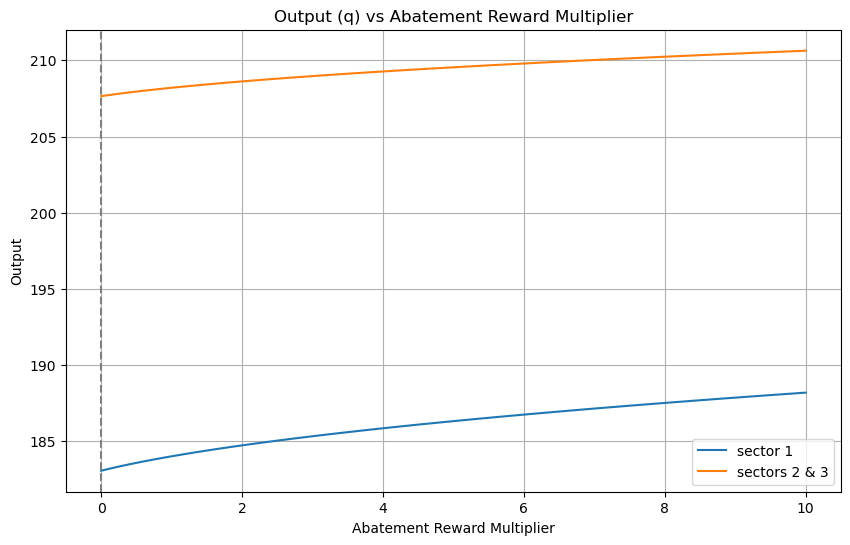

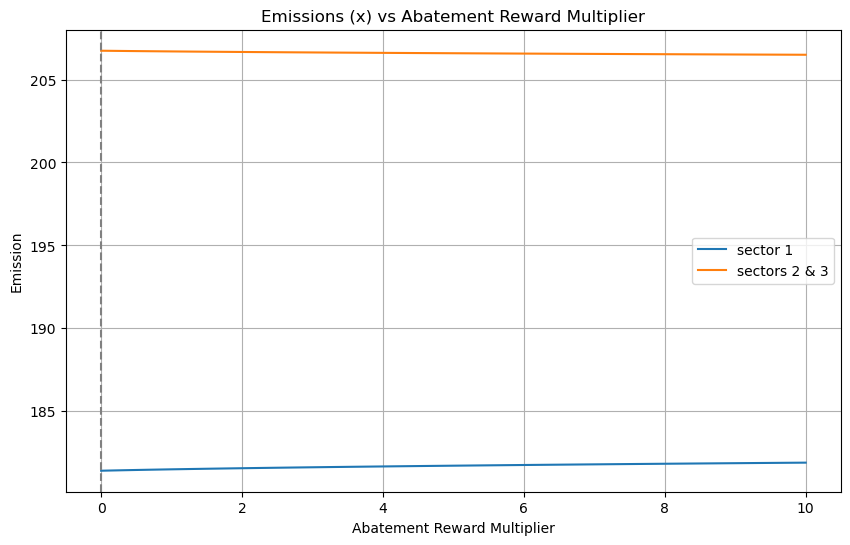

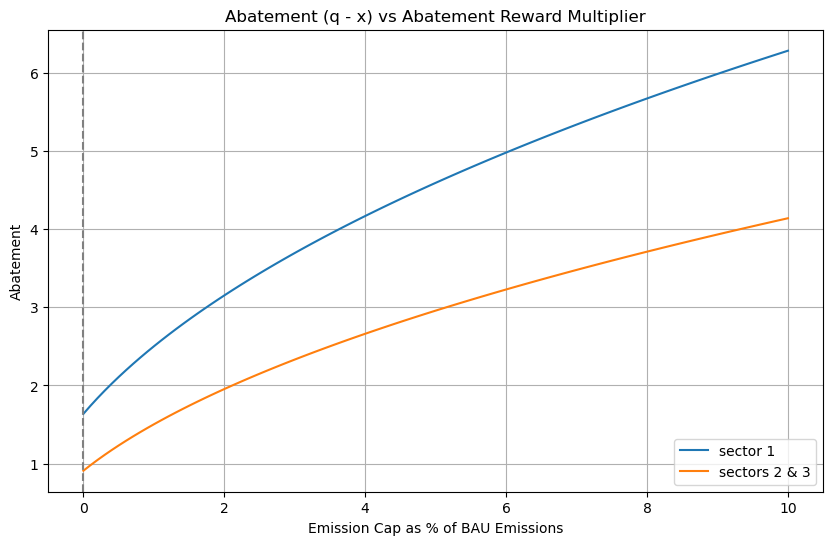

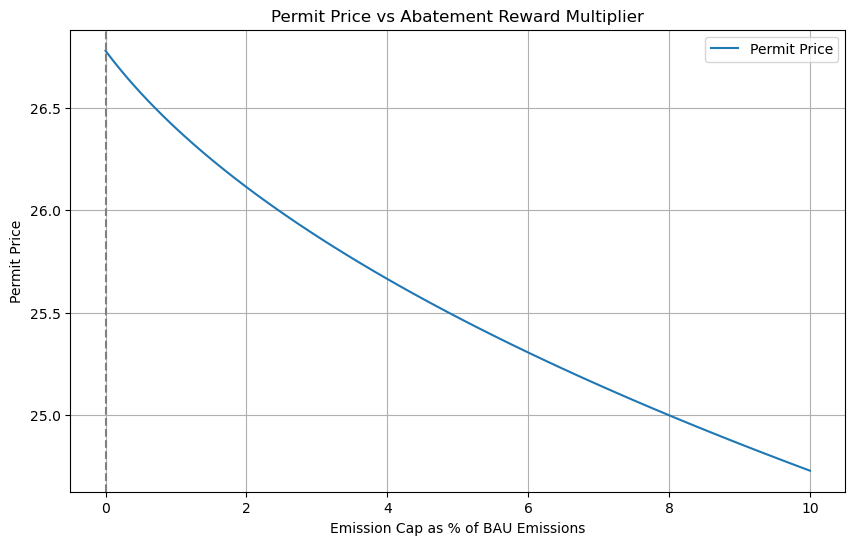

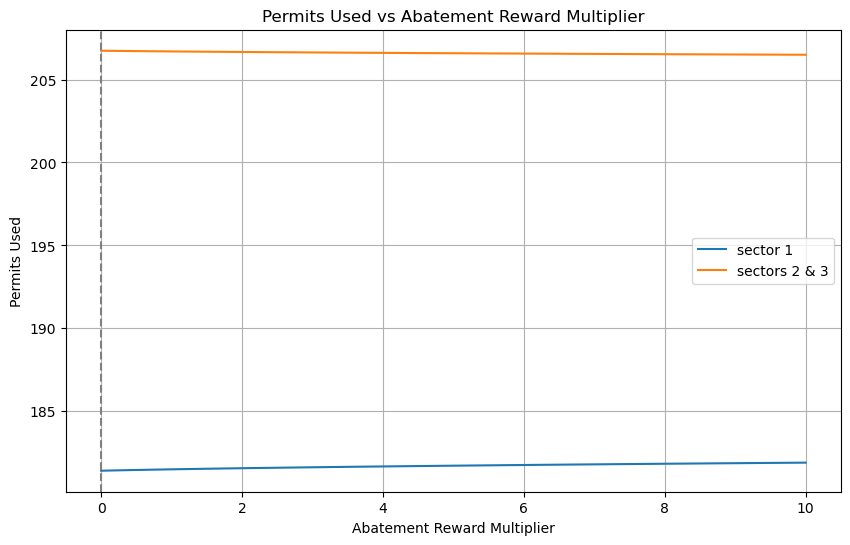

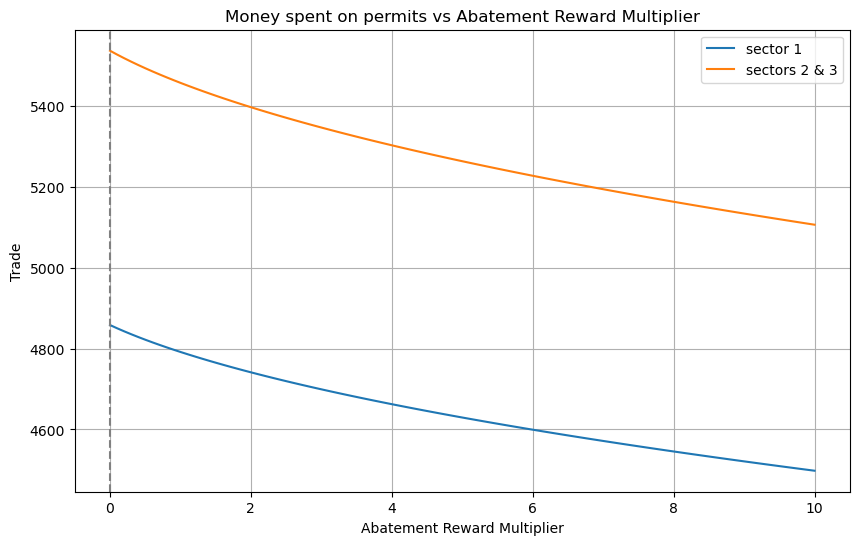

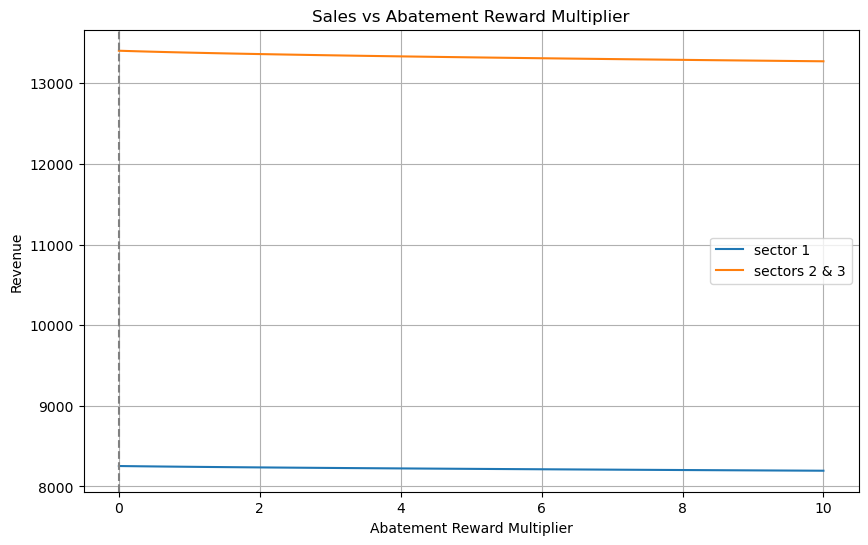

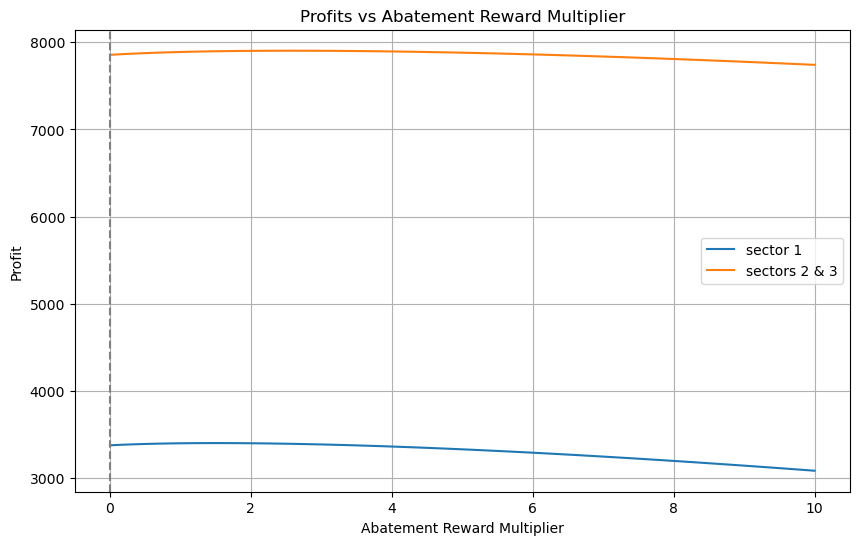

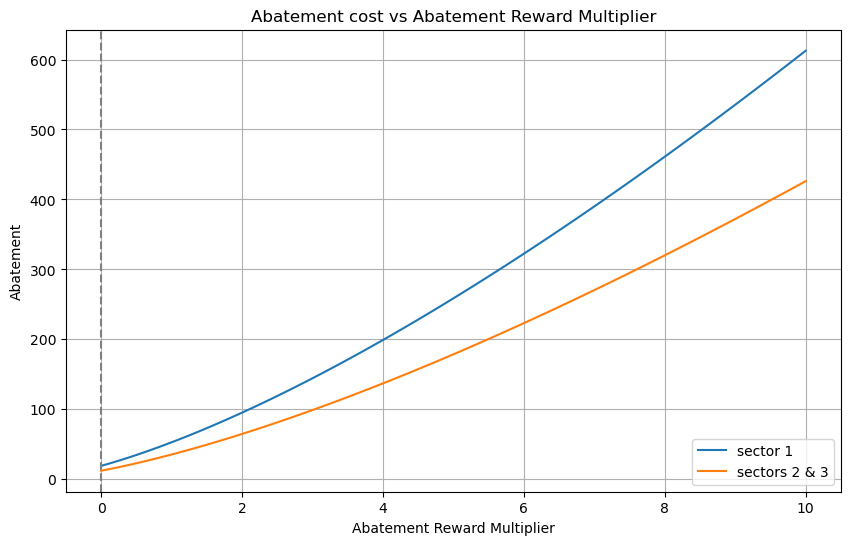

In [10]:
# Define colors
colors = {'trades1': '#1f77b4', 'trades2': '#ff7f0e'}

last_wrong_value = 0

# Define a function to plot the metrics
def plot_metric(metric, ylabel, title):
    plt.figure(figsize=(10, 6))
    plt.plot(frees, results[True][f'{metric}1'], label='sector 1', color=colors['trades1'])
    plt.plot(frees, results[True][f'{metric}2'], label='sectors 2 & 3', color=colors['trades2'])
    plt.axvline(x=last_wrong_value, color='grey', linestyle='--')
    plt.fill_between(frees, plt.ylim()[0], plt.ylim()[1], where=(frees < last_wrong_value), color='grey', alpha=0.3)
    plt.xlabel('Abatement Reward Multiplier')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

# Plot outputs
plot_metric('outputs', 'Output', 'Output (q) vs Abatement Reward Multiplier')

# Plot emissions
plot_metric('emissions', 'Emission', 'Emissions (x) vs Abatement Reward Multiplier')

# Plot the difference output - emission to illustrate the abatement
plt.figure(figsize=(10, 6))
plt.plot(frees, np.array(results[True]['outputs1']) - np.array(results[True]['emissions1']), label='sector 1', color=colors['trades1'])
plt.plot(frees, np.array(results[True]['outputs2']) - np.array(results[True]['emissions2']), label='sectors 2 & 3', color=colors['trades2'])
plt.axvline(x=last_wrong_value, color='grey', linestyle='--')
plt.fill_between(frees, plt.ylim()[0], plt.ylim()[1], where=(frees < last_wrong_value), color='grey', alpha=0.3)
plt.xlabel('Emission Cap as % of BAU Emissions')
plt.ylabel('Abatement')
plt.title('Abatement (q - x) vs Abatement Reward Multiplier')
plt.legend()
plt.grid()
plt.show()

# Plot permit prices
plt.figure(figsize=(10, 6))
plt.plot(frees, results[True]['permit_price'], label='Permit Price', color=colors['trades1'])
plt.axvline(x=last_wrong_value, color='grey', linestyle='--')
plt.fill_between(frees, plt.ylim()[0], plt.ylim()[1], where=(frees < last_wrong_value), color='grey', alpha=0.3)
plt.xlabel('Emission Cap as % of BAU Emissions')
plt.ylabel('Permit Price')
plt.title('Permit Price vs Abatement Reward Multiplier')
plt.legend()
plt.grid()
plt.show()

# Plot permits used
plot_metric('permits', 'Permits Used', 'Permits Used vs Abatement Reward Multiplier')

# Plot trades
plot_metric('trades', 'Trade', 'Money spent on permits vs Abatement Reward Multiplier')

# Plot revenues
plot_metric('revenews', 'Revenue', 'Sales vs Abatement Reward Multiplier')

# Plot profits
plot_metric('profits', 'Profit', 'Profits vs Abatement Reward Multiplier')

# Plot abatements
plot_metric('abatements', 'Abatement', 'Abatement cost vs Abatement Reward Multiplier')

